In [1]:
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np

pd.Series
disaster_data = pd.Series([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
                           1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                           0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                           3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                           0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

# disaster_data = pd.Series([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
#                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
#                            2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
#                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
#                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
#                            3, 3, 1, 4, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
#                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], dtype='float64')
years = np.arange(1851, 1962)

In [2]:

disaster_data = disaster_data.to_frame()
disaster_data['year'] = years

In [104]:
from prior_views.ModelConversion import reduce_data_remove, data_reduce_with_nan
import random

disaster_data = reduce_data_remove(disaster_data, 0.8)


In [106]:
disaster_data

0  year
0    4.0  1851
1    5.0  1852
2    4.0  1853
3    0.0  1854
5    4.0  1856
..   ...   ...
103  0.0  1954
104  0.0  1955
105  1.0  1956
107  0.0  1958
108  1.0  1959

[89 rows x 2 columns]

In [4]:
m_kwars = dict(early_rate_lambda=1, late_rate_lambda=1)

In [132]:
import param

default_selectors = list(data.posterior.data_vars)

class PosteriorDashboard(param.Parameterized):
    data = param.Dict(precedence=-1)
    variable = param.Selector(None)
    percentage = param.Number(default=100, bounds=(80,100), step=5, doc='Percentage of Data:')
    update = param.Integer(1)

    @param.depends('variable','data' , 'percentage', 'update')
    def plot(self):
        return plot_pos(self.data, self.variable)


    def panel(self):
        return pn.Row(self.param, self.plot, sizing_mode='scale_both')

In [133]:
d = {'prior':data, 'prior1':data, 'prior2':data}

pos  = PosteriorDashboard(
            name='Posterior_Dashboard', 
            data=d,
            )

In [86]:
pos.param.update.__set__(obj=value,val=1)

NameError: name 'value' is not defined

In [60]:
v = pos.force_new_dynamic_value('a')
print(v)

0.0


In [55]:
import arviz as az
import panel as pn
from bokeh.layouts import row

def plot_pos(data):
    plots = pn.Column(scroll=True, max_height=750, sizing_mode='stretch_both')
    kwg = dict(height=250, width=550)
    x_axis_range, y_axis_range = None, None
    for key, value in data.items():
        plot = az.plot_density(
            value,
            group='prior', 
            var_names='switchpoint',
            outline=False, 
            backend='bokeh',
            shade=.5, 
            show=False,
            backend_kwargs=kwg
            )
        if x_axis_range == None:
            print(plot[0,0].x_range)
            x_axis_range = plot[0,0].x_range
            y_axis_range = plot[0,0].y_range
        for p in plot[0]:
            p.title.text = key+' '+p.title.text 
            p.legend.visible = False
            p.x_range = x_axis_range
            p.y_range = y_axis_range
        plots.append(row(plot[0].tolist(), sizing_mode='scale_both'))
    col = plots
    return col

In [ ]:
az.plot_ppc(data, legend=True, backend='bokeh')

In [56]:
pl = plot_pos({'prior':data, 'prior2':data})
pn.serve(pl)

DataRange1d(id='3735', ...)
Launching server at http://localhost:59628


In [5]:
with pm.Model() as disaster_model:
    switchpoint = pm.DiscreteUniform('switchpoint', lower=disaster_data['year'].min(), upper = disaster_data['year'].max(), testval=disaster_data['year'].median())

    early_rate = pm.Exponential('early_rate', m_kwars['early_rate_lambda'])
    late_rate = pm.Exponential('late_rate', m_kwars['late_rate_lambda'])

    rate = pm.math.switch(switchpoint >= disaster_data['year'], early_rate, late_rate)

    disasters = pm.Poisson('disasters', rate, observed=disaster_data[0])

    trace = pm.sample()
    prior = pm.sample_prior_predictive()
    posterior = pm.sample_posterior_predictive(trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [71]:
trace.varnames

['switchpoint',
 'early_rate_log__',
 'late_rate_log__',
 'disasters_missing',
 'early_rate',
 'late_rate']

In [6]:
for key, value in prior.items():
    prior[key] = value.astype('float64')

In [7]:
for key, val in posterior.items():
    posterior[key] = val.astype('float64')

In [13]:
prior['switchpoint'] = prior['switchpoint'].astype('float64')

In [16]:
list(posterior.values())[0][0].astype('float64')

array([1., 3., 0., 1., 3., 2., 4., 0., 2., 3., 4., 0., 7., 0., 1., 3., 4.,
       6., 3., 0., 3., 5., 3., 4., 5., 2., 2., 3., 5., 2., 4., 5., 3., 4.,
       2., 3., 8., 1., 5., 0., 5., 1., 0., 0., 1., 0., 1., 0., 0., 2., 0.,
       1., 1., 1., 1., 0., 0., 1., 3., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
       0., 1., 1., 0., 1., 2., 1., 1., 1., 2., 0., 0., 1., 0., 2., 1., 0.,
       0., 0., 0., 0., 1., 0., 1., 1., 2., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 2., 2., 1., 0., 0., 4.], dtype=float32)

In [24]:
import arviz as az
with disaster_model:

    data = az.from_pymc3(
        trace=trace,
        posterior_predictive=posterior,
        prior=prior,
    )

In [28]:
id = az.load_arviz_data("centered_eight")

In [31]:
object_methods = [method_name for method_name in dir(id)
                  if callable(getattr(id, method_name))]

In [76]:
import arviz as az

az.plot_forest(data, backend='bokeh')

array([[Figure(id='12035', ...)]], dtype=object)

In [7]:
ms = {'prio1':m,
        'prior2':m}

In [22]:
def loop(name):   
    i = 1
    temp_name = name
    while temp_name in m_kwars:
    # checks if the name already exists. If so adds a (1) or another int until free slot created
        temp_name = name + '('+ str(i) + ')'
        i+=1
    name = temp_name
    m_kwars[name] = 2
    return name


In [28]:
print(loop('early_rate_lambda2'))

early_rate_lambda2


In [8]:
import panel as pn
t = plot_pos(ms, 100)
pn.serve(t[0][0])

Launching server at http://localhost:59149


In [3]:
def model_method(data, **kwargs):
    with pm.Model() as disaster_model:
        switchpoint = pm.DiscreteUniform('switchpoint', lower=years.min(), upper = years.max(),testval=1900)

        early_rate = pm.Exponential('early_rate', kwargs['early_rate_lambda'])
        late_rate = pm.Exponential('late_rate', kwargs['late_rate_lambda'])

        rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

        disasters = pm.Poisson('disasters', rate, observed=data)

    return disaster_model

In [4]:
%reload_ext autoreload
%autoreload 2
from prior_views.app import app_view

app = app_view(model_method, disaster_data, **m_kwars)

The estimated number of effective samples is smaller than 200 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Launching server at http://localhost:52303
The estimated number of effective samples is smaller than 200 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number

In [5]:
from prior_views.model import model

mod = model(model_method, disaster_data, m_kwars)

The estimated number of effective samples is smaller than 200 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [19]:
mod.model_arviz_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [14]:
import panel as pn
def prior_config_view(original_prior_args, new_prior_args, new_model_name):
        sliders = pn.Column()
        sliders.append(pn.widgets.StaticText(
                                name='Model Config Name', 
                                value=new_model_name
                                )
                            )
        for (key, val), (key2, val2) in zip(original_prior_args.items(), new_prior_args.items()):
            print('key is', key)
            print('key2 is', key2)
            print('val is', val)
            print('val2 is', val2)
            upper_bound = val*1.5
            lower_bound = val*.5
            sliders.append(
                pn.widgets.FloatSlider(
                    name=key,
                    start=lower_bound,
                    end=upper_bound,
                    value=val2,
                    disabled=True,
                )
            )
        return sliders

In [15]:
m_kwars = dict(early_rate_lambda=1, late_rate_lambda=1)
m_kwars_new = dict(early_rate_lambda=.7, late_rate_lambda=1.2)

prior_config_view(m_kwars, m_kwars_new, 'new')

key is early_rate_lambda
key2 is early_rate_lambda
val is 1
val2 is 0.7
key is late_rate_lambda
key2 is late_rate_lambda
val is 1
val2 is 1.2


Column
    [0] StaticText(name='Model Config Name', value='new')
    [1] FloatSlider(disabled=True, end=1.5, name='early_rate_lambda', start=0.5, value=0.7)
    [2] FloatSlider(disabled=True, end=1.5, name='late_rate_lambda', start=0.5, value=1.2)

In [ ]:
app.controls.app.

In [28]:
import random
to_remove = 3
data = disaster_data
data.loc[list(data.loc[random.sample(list(data.index), to_remove)].index)] = np.nan
# df.loc[df.B > 5, :] = np.nan 

In [3]:
from prior_views.ModelConversion import data_reduce_series

data_reduced = data_reduce_series(disaster_data, .95)

In [ ]:
data = disaster_data.replace(to_replace=disaster_data.sample(frac=.05,), value=np.nan)
data_1 = disaster_data.replace(to_replace=disaster_data.sample(frac=.2,), value=np.nan)

In [29]:
data

0      4.0
1      5.0
2      4.0
3      0.0
4      1.0
      ... 
106    0.0
107    0.0
108    1.0
109    0.0
110    1.0
Length: 111, dtype: float64

In [114]:
data.tail()

106    0.0
107    0.0
108    1.0
109    0.0
110    1.0
dtype: float64

In [7]:
def new_model(model_fun, data, **kwargs):
    for key, val in kwargs.items():
        kwargs[key] = val + (val*.2)

    model = model_fun(data, **kwargs)
    return model

In [7]:
%reload_ext autoreload
%autoreload 2
from prior_views.model import model

new_model = model(model_method, disaster_data, m_kwars)

The estimated number of effective samples is smaller than 200 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [8]:
new_model

In [5]:
import time
from tqdm import tqdm

for i in tqdm(range(10)):
   time.sleep(3)

100%|██████████| 10/10 [00:30<00:00,  3.00s/it]


In [10]:
m = {'model': new_model, 'model_2':new_model}

In [11]:
list(m.values().model_arviz_data)

AttributeError: 'dict_values' object has no attribute 'model_arviz_data'

In [40]:
class CustomExample(param.Parameterized):
    sliders = []
    for key, val in m_kwars.items():
        upper_bound = val*1.5
        lowe_bound = val*.5
        sliders.append(param.Number(default=val, bounds=(lowe_bound,upper_bound)))

In [55]:
import param
def model_selector(prior_args:dict):
    sliders = []
    for key, val in prior_args.items():
        upper_bound = val*1.5
        lowe_bound = val*.5
        sliders.append(pn.widgets.FloatSlider(name=key, start=lowe_bound, end=upper_bound, value=val))

    return sliders

In [117]:
s = model_selector(m_kwars)
col = pn.Column()
for i in s:
    col.append(i)
col

Column
    [0] FloatSlider(end=1.5, name='early_rate_lambda', start=0.5, value=1)
    [1] FloatSlider(end=1.5, name='late_rate_lambda', start=0.5, value=1)

In [116]:
col.

SyntaxError: invalid syntax (<ipython-input-116-84a0b696d7cf>, line 1)

In [112]:
import functools

def print_dict(vals:dict):
    for key, val in vals.items():
        print(key)
        print(val)

button = pn.widgets.Button(name='Click me', button_type='primary')
text = pn.widgets.TextInput(value='Ready')

def on_button_clicked(event, rs_):
    new_config = {}
    for s in rs_:
        print
        new_config[s.name]=s.value
    print_dict(new_config)

button.on_click(functools.partial(on_button_clicked, rs_=col)) 
row = pn.Row(col, button, text)
pn.serve(row)


Launching server at http://localhost:60345
early_rate_lambda
1.2
late_rate_lambda
0.7


In [65]:
col[0].value

1

In [13]:
from prior_views.Dashboards import PosteriorDashboard
import panel as pn
def pos_dash():
    dash = PosteriorDashboard(name='posterior_dashboard',data=m)
    dash.param.variable.objects = list(list(new_model.posteriors.values())[0].data_vars)
    dash.param.variable.default = 0
    return dash.panel().servable()

In [14]:
import panel as pn
from tornado.ioloop import IOLoop
import nest_asyncio

pn.extension()
loop = IOLoop().current()
server = pn.serve(pos_dash, show=False, loop=loop, start=False)
# nest_asyncio required because if opening in jupyter notebooks, IOloop is already in use
nest_asyncio.apply()

Launching server at http://localhost:62799


In [82]:
new_model(model_method, disaster_data, **m_kwars)

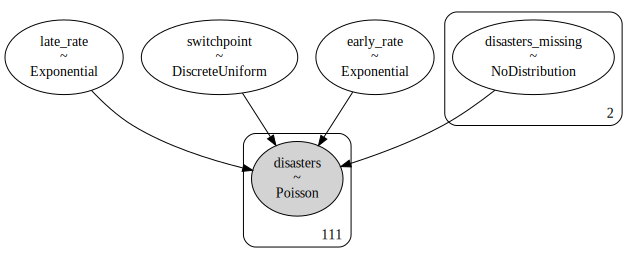

In [68]:
mod = model_method(disaster_data, **m_kwars)
pm.model_to_graphviz(mod)

In [57]:
import inspect

args = model_method()


{'early_rate_lambda': 1,
 'late_rate_lambda': 1,
 'data': 0      4.0
 1      5.0
 2      4.0
 3      0.0
 4      1.0
       ... 
 106    0.0
 107    0.0
 108    1.0
 109    0.0
 110    1.0
 Length: 111, dtype: float64}

In [46]:
sig.replace('data')

TypeError: replace() takes 1 positional argument but 2 were given

<Parameter "data=0      4.0
1      5.0
2      4.0
3      0.0
4      1.0
      ... 
106    0.0
107    0.0
108    1.0
109    0.0
110    1.0
Length: 111, dtype: float64">

In [6]:
with pm.Model() as disaster_model_1:
    switchpoint = pm.DiscreteUniform('switchpoint', lower=years.min(), upper = years.max(),testval=1900)



    early_rate = pm.Exponential('early_rate', .8)
    late_rate = pm.Exponential('late_rate', .8)

    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson('disasters', rate, observed=disaster_data)

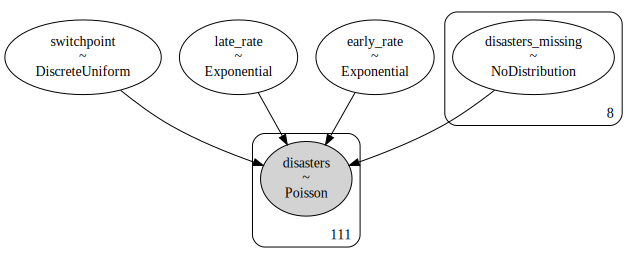

In [5]:
pm.model_to_graphviz(disaster_model_1)

In [107]:
with pm.Model() as disaster_model_2:
    switchpoint = pm.DiscreteUniform('switchpoint', lower=years.min(), upper = years.max(),testval=1900)



    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)

    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson('disasters', rate, observed=data_1)

In [108]:
with pm.Model() as disaster_model_3:
    switchpoint = pm.DiscreteUniform('switchpoint', lower=years.min(), upper = years.max(),testval=1900)



    early_rate = pm.Exponential('early_rate', 1.2)
    late_rate = pm.Exponential('late_rate', 1.2)

    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson('disasters', rate, observed=disaster_data)

In [6]:
with disaster_model_1:
    trace = pm.sample()
    prior = pm.sample_prior_predictive()
    posterior = pm.sample_posterior_predictive(trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [8]:
import arviz as az
import panel as pn

with disaster_model_1:
        trace = pm.sample()
        prior = pm.sample_prior_predictive()
        posterior = pm.sample_posterior_predictive(trace)
        data = az.from_pymc3(
                        trace=trace,
                        prior=prior,
                        posterior_predictive=posterior,
                )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [9]:
data.posterior

<xarray.Dataset>
Dimensions:                  (chain: 4, disasters_missing_dim_0: 2, draw: 1000)
Coordinates:
  * chain                    (chain) int64 0 1 2 3
  * draw                     (draw) int64 0 1 2 3 4 5 ... 995 996 997 998 999
  * disasters_missing_dim_0  (disasters_missing_dim_0) int64 0 1
Data variables:
    switchpoint              (chain, draw) int64 1889 1889 1889 ... 1892 1892
    disasters_missing        (chain, draw, disasters_missing_dim_0) int64 0 ... 4
    early_rate               (chain, draw) float64 2.888 2.872 ... 3.41 3.889
    late_rate                (chain, draw) float64 0.9054 1.051 ... 0.9694 1.043
Attributes:
    created_at:                 2020-08-12T11:36:38.747819
    arviz_version:              0.9.0
    inference_library:          pymc3
    inference_library_version:  3.9.2
    sampling_time:              3.7086660861968994
    tuning_steps:               1000

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f888a652ad0>],
      dtype=object)

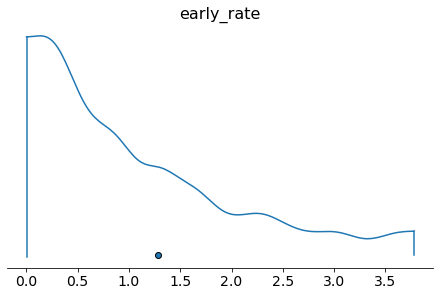

In [104]:
az.plot_density(pm_data,group='prior', var_names='early_rate')

In [5]:
def convert_models(models=[]):
    model_data = []
    for m in models:
        with m:
            trace = pm.sample(1000)
            prior = pm.sample_prior_predictive(1000)
            posterior = pm.sample_posterior_predictive(trace)
            data = az.from_pymc3(
                        trace=trace,
                        prior=prior,
                        posterior_predictive=posterior,
                        model=d
                    )
            model_data.append(data)
    return model_data

In [109]:
m = [disaster_model_1, disaster_model_2, disaster_model_3]
# data_m = convert_models(m)
# models = {
#   "prior_.8": data_m[0],
#   "prior_1": data_m[1],
#   "prior_1.2": data_m[2]
# }

In [21]:
v = None
v = list(mods.values())[0]
v

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [110]:
from prior_views.ModelConversion import convert_models

mods = convert_models(m)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
The number of effective samples is smaller than 25% for some parameters.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [65]:
import bokeh as Bokeh
import bokeh.plotting as bkp
from bokeh.models import Div
from bokeh.layouts import column, row
from bokeh.io import curdoc
import arviz as az
import panel as pn


def prior_density_plot(variable='switchpoint',data=mods, plottype='Same Plots'):
    """
    Method for producing the prior kde plot using arviz plot_density. This is done 2 ways: either will produce all     the plots onto one graph or will produe them seperately

    The parameters are the data, plottype, either "Seperate Plots" or "Same Plots" 

    Also takes the variable to view which will be chosen by the dropdown in the program. Probably shouldnt be          hardcoded with a default as this will change with each model.  *** Will change later ***
    """
    if plottype == 'Seperate Plots':
        plots = []
        for key, value in data.items():
            kwg = dict(title=key, width=1000)
            curdoc().theme = 'dark_minimal'
            plot = az.plot_density(
                value,
                group='prior', 
                var_names=variable,
                outline=False, 
                backend='bokeh',
                shade=.5, 
                show=False,
                backend_kwargs=kwg,
                )
            for p in plot[0]:
                p.title.text = key+' '+p.title.text 
            """ ** Can't get the title to change with kwargs so workaround with html div ** """
            plots.append(column(Div(text='<h2>'+key+'</h2>'),row(plot[0].tolist(), sizing_mode='scale_both')))
        col = column(plots)
    else:
        curdoc().theme = 'dark_minimal'
        kwg = dict(height=350, width=500,toolbar_location='right')
        plot = az.plot_density(
            list(data.values()), 
            group='prior', 
            var_names=variable,
            outline=False,  
            backend='bokeh',
            shade=.5, 
            show=False, 
            colors='cycle',
            data_labels=list(data.keys()),
            backend_kwargs=kwg,
            )
        return plot
    return col

pl = prior_density_plot()

In [67]:
pl[0,0].min_border_top = 10

In [68]:
from bokeh.models import Legend
from bokeh.plotting import figure

for p in pl[0]:
    l = p.legend[0]
    p.legend.location = 'bottom_left'
    l.location = (10,-10)
    l.orientation = "vertical"
    p.add_layout(l, place='right')

pn.serve(pl[0,0])


Launching server at http://localhost:61416


In [111]:
%reload_ext autoreload
%autoreload 2
from prior_views.CreateApp import prior_checking_tool, create_app

prior_checking_tool(mods)

Launching server at http://localhost:65406


In [35]:
import bokeh as Bokeh
import bokeh.plotting as bkp
from bokeh.models import Div
from bokeh.layouts import column, row
from bokeh.io import curdoc

def prior_density_plot(variable,data=models, plottype='Seperate Plots'):
    """
    Method for producing the prior kde plot using arviz plot_density. This is done 2 ways: either will produce all     the plots onto one graph or will produe them seperately

    The parameters are the data, plottype, either "Seperate Plots" or "Same Plots" 

    Also takes the variable to view which will be chosen by the dropdown in the program. Probably shouldnt be          hardcoded with a default as this will change with each model.  *** Will change later ***
    """
    if plottype == 'Seperate Plots':
        plots = []
        for key, value in data.items():
            kwg = dict(title=key)
            curdoc().theme = 'dark_minimal'
            plot = az.plot_density(
                value,
                group='prior', 
                var_names=variable,
                outline=False, 
                backend='bokeh',
                shade=.5, 
                show=False,
                backend_kwargs=kwg,
                num_pp_samples=1,
                )
            """ ** Can't get the title to change with kwargs so workaround with html div ** """
            plots.append(column(Div(text='<h2>'+key+'</h2>'),row(plot[0].tolist(), sizing_mode='scale_both')))
        col = column(plots)
    else:
        curdoc().theme = 'dark_minimal'
        plot = az.plot_density(
            list(data.values()), 
            group='prior', 
            var_names=variable,
            outline=False,  
            backend='bokeh',
            shade=.5, 
            show=False, 
            colors='cycle'
            )
        col = column(plot[0].tolist())
    return col


def posterior_density_plot(data=models, plottype='Seperate Plots', variable='switchpoint'):
    """
    Basically the sama as the prior density plot but uses the posterior instead. Could have resused the same           method with an extra param but the panel.interact method tries to create features for parameter selection          which i dont want in this case

    *** will try to find a workaround for this feature to reduce unnescesary code copying***
    """
    if plottype == 'Seperate Plots':
        plots = []
        for key,value in data.items():
            curdoc().theme = 'dark_minimal'
            kwg = dict(title=key)
            plot = az.plot_density(
                value, 
                group='posterior', 
                var_names=variable, 
                backend='bokeh',
                outline=False,
                shade=.5, 
                show=False,
                backend_kwargs=kwg
                )
            plots.append(column(Div(text='<h2>'+key+'</h2>'),row(plot[0].tolist(), sizing_mode='scale_both')))
        col = column(plots)
    else:
        curdoc().theme = 'dark_minimal'
        plot = az.plot_density(
            list(data.values()), 
            group='posterior', 
            var_names=variable, 
            backend='bokeh',
            shade=.5, 
            show=False, 
            colors='cycle',
            outline=False, 
            )
        col = column(plot[0].tolist())
    return col


def prior_predictive_density_plot(data=models, variable="switchpoint"):
    plots = []
    for key, value in data.items():
        kwg = dict(title=key)
        curdoc().theme = 'dark_minimal'
        plot = az.plot_ppc(
            value, 
            group='prior', 
            var_names=variable, 
            backend='bokeh',
            alpha=.5, 
            show=False,
            backend_kwargs=kwg
            )
        plots.append(column(Div(text='<h2>'+key+'</h2>'),row(plot[0].tolist(), sizing_mode='scale_both')))
    col = column(plots)
    return col

def posterior_predictive_density_plot(data=models,variable="switchpoint"):
    plots = []
    for key, value in data.items():
        kwg = dict(title=key)
        curdoc().theme = 'dark_minimal'
        plot = az.plot_ppc(
            value, 
            group='posterior', 
            var_names=variable, 
            backend='bokeh',
            alpha=.5, 
            show=False,
            backend_kwargs=kwg
            )
        plots.append(row(plot[0].tolist(), sizing_mode='scale_both'))
    col = column(plots)
    return col


def sample_trace_plot(data=models,variable="switchpoint"):
    plots = []
    for key, value in data.items():
        kwg = dict(height=200,title=key)
        curdoc().theme = 'dark_minimal'
        plot = az.plot_trace(
            value, 
            var_names=variable, 
            backend='bokeh', 
            show=False,
            backend_kwargs=kwg
            )
        plots.append(column(Div(text='<h2>'+key+'</h2>'),row(plot[0].tolist(), sizing_mode='scale_both')))
    col = column(plots)
    return col

In [22]:
p = prior_predictive_density_plot(models, variable='disasters')
pn.serve(p)

Launching server at http://localhost:49823


In [24]:
    from bokeh.plotting import curdoc, figure
    import arviz as az

    kwg = dict(height=200,title='plot')    
    curdoc().theme = 'dark_minimal'
    plot = az.plot_trace(
        pm_data, 
        var_names=None, 
        backend='bokeh', 
        backend_kwargs=kwg,
        show=False
        )
    pn.serve(plot)

Launching server at http://localhost:54467


In [29]:
from bokeh.layouts import row

az.style.use("arviz-darkgrid")
plots = []
for value in data_m:
    plot = az.plot_density(value, group='posterior', var_names='disasters_missing', backend='bokeh',shade=.5, show=False)
    plots.append(row(plot[0].tolist()))
grid = column(plots)
pn.serve(grid)
# grid = row(plots)
# g = column(grid)
# pn.serve(grid)

Launching server at http://localhost:51152


In [36]:
from bokeh.plotting import show



pn.extension()

radio_group = pn.widgets.RadioButtonGroup(
    name='Radio Button Group', options=['Same Plot', 'Seperate Plots'], button_type='success')

def prior_view_tab():
    kw = dict(variable=sorted(list(pm_data.prior.data_vars)), plottype=radio_group)
    i = pn.interact(prior_density_plot, **kw)
    text = "Hey"
    p = pn.Row(text,pn.Row(pn.Column(i[0][1],i[0][0]),i[1]))
    return p



def posterior_view_tab():
    kw = dict(variable=sorted(list(pm_data.posterior.data_vars)),plottype=radio_group)
    i = pn.interact(posterior_density_plot, **kw)
    text = "Hey"
    p = pn.Row(text,pn.Row(pn.Column(i[0][1],i[0][0]),i[1]))
    return p

def prior_predictive_view_tab():
    kw = dict(variable=sorted(list(pm_data.prior_predictive.data_vars)))
    i = pn.interact(prior_predictive_density_plot, **kw)
    text = "Hey"
    p = pn.Row(text,pn.Row(i[0],i[1]))
    return p

def posterior_predictive_view_tab():
    kw = dict(variable=sorted(list(pm_data.posterior_predictive.data_vars)))
    i = pn.interact(posterior_predictive_density_plot, **kw)
    text = "Hey"
    p = pn.Row(text,pn.Row(i[0],i[1]))
    return p

def sample_trace_view_tab():
    kw = dict(variable=sorted(list(pm_data.posterior.data_vars)))
    i = pn.interact(sample_trace_plot, **kw)
    text = "Hey"
    p = pn.Row(text,pn.Row(i[0],i[1]))
    return p

In [38]:
tabs = pn.Tabs(('Prior', prior_view_tab),('Prior Predictive', prior_predictive_view_tab),('Posterior', posterior_view_tab),('Posterior Predictive',posterior_predictive_view_tab),('Sample Trace', sample_trace_view_tab))
pn.serve(tabs)

Launching server at http://localhost:56950
